# Prophet

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Introduction

In this lecture we will learn about [Prophet](https://facebook.github.io/prophet/), a framework for forecasting time series developed by Meta (former Facebook) in 2017.

- Prophet is based on an *additive model* where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data, shifts in the trend, and typically handles outliers well.

In the following, we will cover:

- The main components of the Prophet model: trend, seasonality, and holidays.
- How to use the prophet library in Python to perform time series forecasting.
- Try more advanced options and configurations available within the Python library.

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

---

## Model components

- Prophet models a time series $y(t)$ as a combination of three components: 

  1. trend $g(t)$, 
  2. seasonality $s(t)$, 
  3. holidays $h(t)$. 

- The model equation is:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

- where $\epsilon_t$ is the error term assumed to be normally distributed.

### Trend component $g(t)$

- The trend component models non-periodic changes in the value of the time series. 
- Prophet provides two options for modeling the trend:
  - Piece-wise linear growth model.
  - Logistic growth model.

#### Piece-wise linear growth model

- A piece-wise linear function can accommodate changes in the trend's direction over time.
- This is particularly useful for time series data exhibiting shifts in growth rates due to external factors or internal changes. 
- This allows to capture and forecast time series trends that do not follow a specific form (linear or logistic).

- In a piece-wise linear trend model, the time series is divided into *segments*.
- In each segment, the trend is modeled as a linear function. 
- The points where the trend changes direction are called *change points*. 

- Prophet allows users to specify the *maximum number* of potential change points or to let the algorithm automatically estimate it based on the data.
- Prophet automatically detects the change points, allowing the trend to adjust its slope at these points, hence capturing shifts in the trend's direction.

- Users can adjust the flexibility of the model in capturing trend changes by tuning the change point *prior scale* parameter. 
    - A higher prior scale makes the model more sensitive to changes (allowing more flexibility).
    - A lower prior scale makes the model less sensitive to fluctuations (resulting in a smoother trend).

The piece-wise linear trend model in Prophet is defined as:

$$g(t) = (k + a(t)^\top \delta) \cdot t + (g_0 + a(t)^\top \gamma)$$

where:
- $g(t)$ is the trend component at time $t$,
- $k$ is the initial growth rate,
- $a(t)$ is a vector where each element is: 
    - the amount of time since the corresponding change point, if $t$ is after a change point;
    - 0 otherwise.
- $\delta$ represents adjustments to the growth rate at each change point,
- $g_0$ is the offset (intercept), i.e., the value at $t=0$,
- $\gamma$ compensates for discontinuities in the trend at each change point, ensuring the trend is continuous.

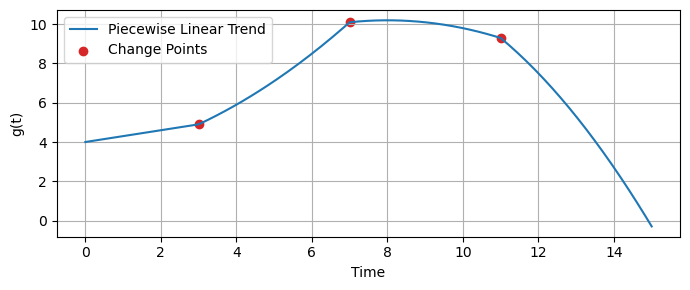

In [2]:
change_points = [3, 7, 11]           # Times at which changes occur
k = 0.3                              # Initial growth rate
delta = np.array([0.1, -0.2, -0.1])  # Adjustments to growth rate
g0 = 4.0                             # Initial offset
gamma = np.array([0.3, -0.1, 0.1])   # Compensations for discontinuities

def compute_a(t, change_points):
    return np.array([max(0, t - cp) for cp in change_points])

def compute_g(t, k, delta, g0, gamma, change_points):
    a_t = compute_a(t, change_points)
    trend = (k + np.dot(a_t, delta)) * t + (g0 + np.dot(a_t, gamma))
    return trend

time_points = np.linspace(0, 15, 200) 
g_values = [compute_g(t, k, delta, g0, gamma, change_points) for t in time_points]

plt.figure(figsize=(7, 3))
plt.plot(time_points, g_values, label="Piecewise Linear Trend")
plt.scatter(change_points, [compute_g(cp, k, delta, g0, gamma, change_points) for cp in change_points], color='tab:red', label="Change Points")
plt.xlabel("Time")
plt.ylabel("g(t)")
plt.legend()
plt.grid(True)
plt.tight_layout();

**⚙ Try it yourself**

- Try modifying the parameters `change_points`, `k`,  `delta`, `g0`, and `gamma` to see how piece-wise linear trend above change.

#### Logistic growth model

The Logistic growth model is used to describe a population that:
- Grows rapidly when it's small.
- Grows slowlier as it approaches a maximum limit (*carrying capacity*) that it cannot exceed.
- Eventually levels off when the carrying capacity is reached (*saturating growth*).

*Carrying capacity*

- Is a concept borrowed from population biology. 
- It refers to the maximum population size that an environment can sustain without being degraded. 
- For business metrics, this could represent a market saturation point, such as the maximum number of users a platform can support due to limitations in infrastructure or market size.

*Saturating growth*

- It refers to a growth pattern where increments become progressively smaller as the value approaches the carrying capacity. 
- When the values are far below the carrying capacity, growth can be rapid (there is a lot of "room" to grow).
- As the values approach the carrying capacity, the growth rate decreases, and the time series levels off, reflecting a saturation point where further growth becomes increasingly difficult.

The formula describing the Logistic trend is:

$$g(t) = \frac{C}{1 + e^{-k(t - m)}}$$

where:
- $k$ is the growth rate,
- $C$ is the carrying capacity (the maximum achievable value),
- $t$ is time,
- $m$ is the point in time where growth is halfway to the carrying capacity.

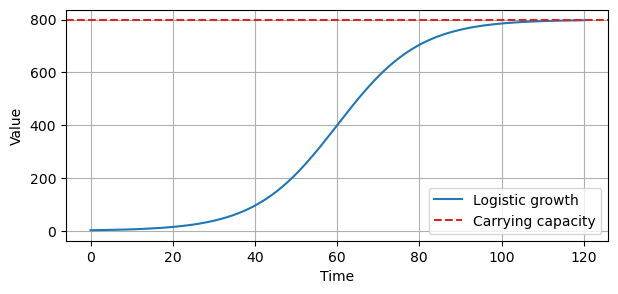

In [3]:
def logistic_growth(t, C, k, m):
    return C / (1 + np.exp(-k * (t - m)))

# Parameters
C = 800   # carrying capacity
k = 0.1   # growth rate
m = 60    # offset parameter, indicating the inflection point

t = np.linspace(0, 120, 200)
y = logistic_growth(t, C, k, m)

plt.figure(figsize=(7, 3))
plt.plot(t, y, label='Logistic growth')
plt.xlabel('Time')
plt.ylabel('Value')
plt.axhline(C, color='tab:red', linestyle='--', label='Carrying capacity')
plt.legend()
plt.grid(True)
plt.show()

**⚙ Try it yourself**

- Try setting `m=20` to see how the curve changes.
- Try also modifying the values of `k` and `C`.

### Seasonality component $s(t)$

The seasonality component $s(t)$ models periodic changes, which can be yearly, weekly, or daily. 

Prophet uses Fourier series to model these periodic changes, allowing for flexibility in capturing seasonality.

$$s(t) = \sum_{n=1}^{N} \left(a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right)\right)$$

where:
- $N$ is the number of Fourier terms (higher $N$ captures more detailed seasonal patterns),
- $P$ is the period (e.g., 365.25 for yearly seasonality),
- $a_n$ and $b_n$ are the Fourier series coefficients that are fitted to the data.

### Holidays and events $h(t)$

- The holiday component $h(t)$ models irregular - but predictable - events. 
- This component is represented as a series of indicator functions that equal 1 if the time $t$ corresponds to a holiday and 0 otherwise. 
- Coefficients associated with these indicators are fitted to measure the impact of holidays on the forecast.

The holiday component $h(t)$ is defined as

$$h(t) = \sum_{i} I(t \in D_i) \cdot \delta_i$$

where:
- $D_i$ represents the set of times corresponding to holiday $i$,
- $I$ is an indicator function,
- $\delta_i$ is the effect of holiday $i$ on the time series, which can be tuned.

#### Seasonal and holiday effects adjustment

- Like for piece-wise linear trend, Prophet can adjust for overfitting or underfitting of seasonal and holiday effects by changing the *prior scale* of these components. 
- A *larger* prior scale allows the model to fit larger seasonal fluctuations.
- A *smaller* scale regularizes the model, preventing it from overfitting seasonal and holiday effects.

---

## Fitting the Model

- The components described above are combined into the overall model.
- To fit the Prophet model to historical data the model's parameters are estimated using maximum likelihood estimation or Bayesian sampling. 
- This involves optimizing the parameters to minimize the difference between the observed and predicted values of the time series.

- The optimization is usually done through gradient descent methods.
- To perform the optimization Prophet relies on [Stan](https://mc-stan.org/), a C++ library for statistical modeling and high-performance statistical computation that makes model fitting very fast.

---

## Prophet in Python

- The input to Prophet is always a dataframe with two columns: `ds` and `y`. 
- Be sure to rename your dataframe with these column names.
- The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. 
- The `y` column must be numeric, and represents the measurement we wish to forecast.

- As an example, we'll look at a time series of daily page views for the Wikipedia page of [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning), a former football player. 
- This is a nice example because it illustrates some of Prophet’s features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning’s playoff and superbowl appearances).

In [4]:
data_path = 'https://raw.githubusercontent.com/PinkWink/DataScience/master/data/07.%20example_wp_peyton_manning.csv'
peyton = pd.read_csv(data_path)
peyton.head()

,ds,y
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680


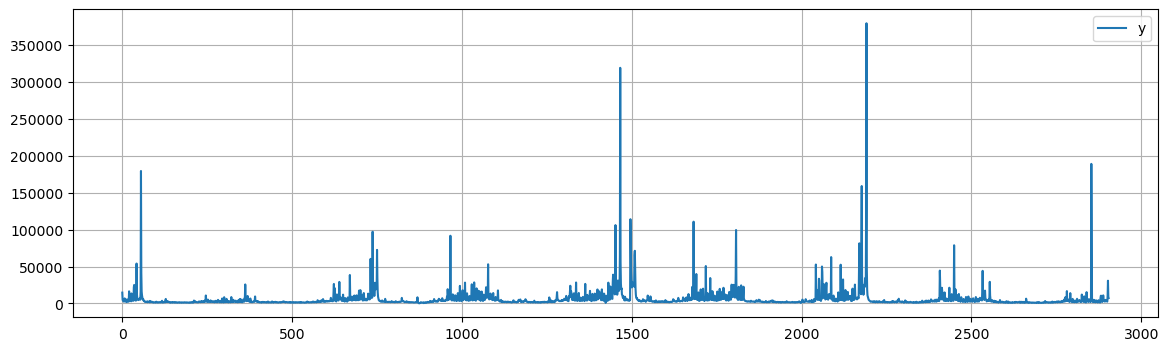

In [5]:
peyton.plot(figsize=(14, 4), grid=True);

- Since there are big spikes in the data, we will apply a logarithm transformation to obtain a more even range of variation in the data.

In [6]:
peyton['y'] = np.log(peyton['y'])
peyton.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


- The log transformation clearly stabilized the variance in the data, as we can see from the plot.

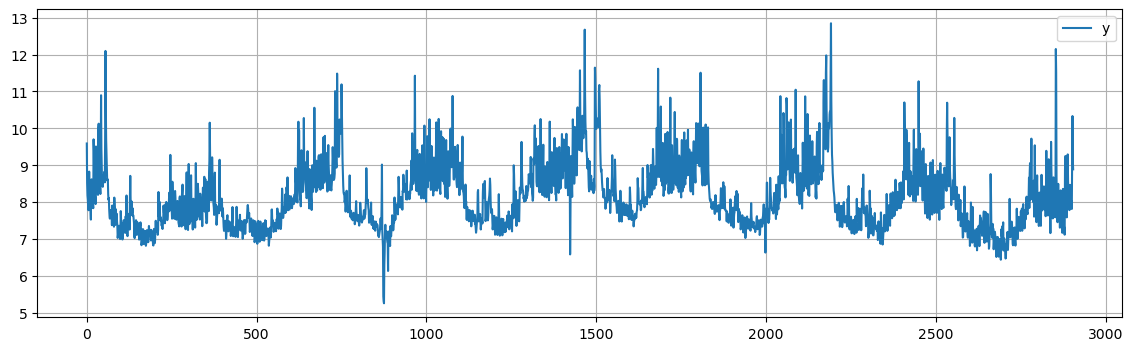

In [7]:
peyton.plot(figsize=(14, 4), grid=True);

- Next, we instantiate a new Prophet object.
- We can specify several parameters such as:
  - `growth='linear'`, meaning that we use a piece-wise linear function to model the trend. Other options are `'logistic'` or `'flat'` to specify a logistic or flat trend, respectively.
  - `seasonality_mode='additive'`. The other option is `'multiplicative'`.
  - `interval_width=0.90` specifies the wifth of the uncertainty intervals for the forecast.

In [8]:
model = Prophet(growth='linear', seasonality_mode='additive', interval_width=0.90)

- Once the model is instantiated, we call its fit method and pass to it the historical dataframe. 
- Fitting should take 1-2 seconds.

In [9]:
model.fit(peyton);

19:44:23 - cmdstanpy - INFO - Chain [1] start processing
19:44:23 - cmdstanpy - INFO - Chain [1] done processing


- Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. 
- You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. 
- `periods=365` specifies the length of our forecast.
- `freq='D'` specifies that the units (`365` in this case) represent days.
- By setting `include_history=True` it will also include the dates used for training, so we can also see the model.

In [10]:
future = model.make_future_dataframe(periods=365, freq='D', include_history=True)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


- The `predict` method will assign each row in `future` a predicted value `yhat`.
- By giving also historical dates (`include_history=True`), it will provide an in-sample fit. 
- The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast and many other columns, including those with uncertainty intervals.

In [11]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.185052,7.286944,9.231088,6.691742,7.735753,1.018148,1.018148,1.018148,0.048256,0.048256,0.048256,0.969892,0.969892,0.969892,0.0,0.0,0.0,8.203200
3266,2017-01-16,7.184020,7.635259,9.512621,6.688793,7.737977,1.344221,1.344221,1.344221,0.352303,0.352303,0.352303,0.991918,0.991918,0.991918,0.0,0.0,0.0,8.528241
3267,2017-01-17,7.182988,7.429654,9.244919,6.686424,7.740201,1.132648,1.132648,1.132648,0.119651,0.119651,0.119651,1.012997,1.012997,1.012997,0.0,0.0,0.0,8.315636
3268,2017-01-18,7.181957,7.237511,9.118228,6.684204,7.742096,0.966266,0.966266,0.966266,-0.066662,-0.066662,-0.066662,1.032928,1.032928,1.032928,0.0,0.0,0.0,8.148223
3269,2017-01-19,7.180925,7.223551,9.109510,6.681984,7.743405,0.979215,0.979215,0.979215,-0.072249,-0.072249,-0.072249,1.051464,1.051464,1.051464,0.0,0.0,0.0,8.160140


- You can plot the forecast by calling the `Prophet.plot` method and passing in the `forecast` dataframe.

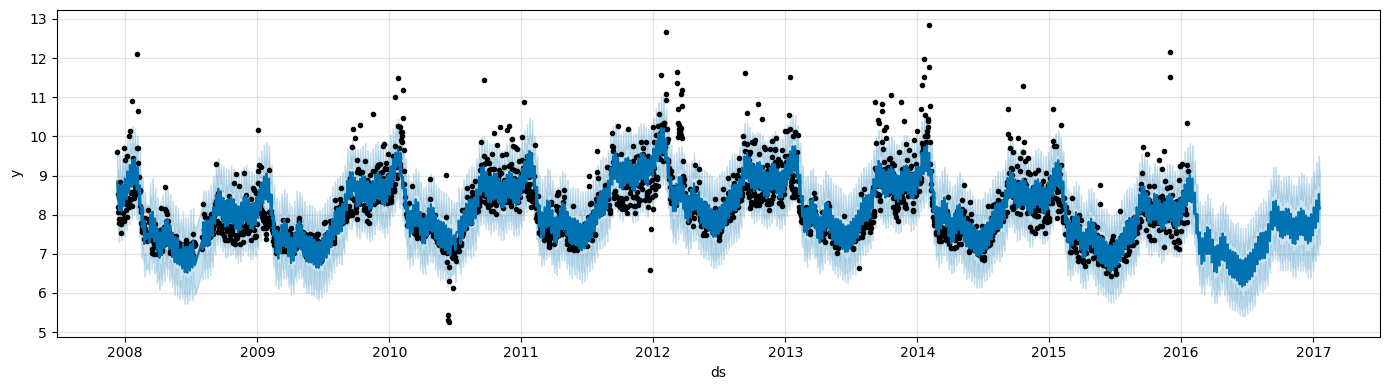

In [12]:
fig1 = model.plot(forecast, figsize=(14, 4))

- If you want to see the forecast components, you can use the `Prophet.plot_components` method. 
- By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
- If you include holidays, you’ll see those here, too.

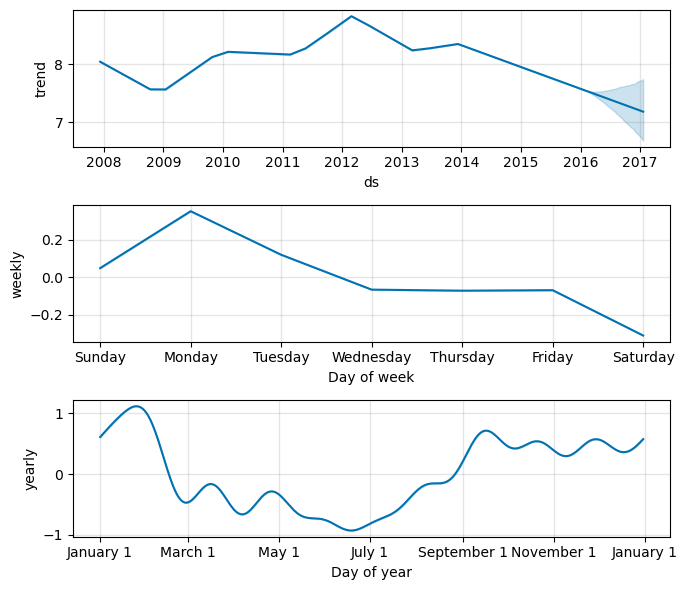

In [13]:
fig2 = model.plot_components(forecast, figsize=(7, 6))

- An interactive figure of the forecast and components can be created with `plotly`.

In [14]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [15]:
plot_components_plotly(model, forecast)

### Modeling holidays and special events

- If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. 
- It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. 
- It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). 
- If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

- You can also include columns `lower_window` and `upper_window` which extend the holiday out to [`lower_window`, `upper_window`] days around the date. 
- For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include `'lower_window': -1` and `'upper_window': 0`. 

Here we create a dataframe that includes the dates of all of Peyton Manning’s playoff appearances:

In [16]:
# add holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0, # this specifies spillover into previous days
  'upper_window': 1, # this for the future days
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays_df = pd.concat((playoffs, superbowls))

- Above we have included the superbowl days as both playoff games and superbowl games. 
- This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once `holidays_df` is created, holiday effects are included in the forecast by passing them in with the `holidays` argument of the constructor.

In [17]:
# fit and predict
model_holyday = Prophet(holidays=holidays_df, # this includes the holidays
                        growth='linear', seasonality_mode='additive', interval_width=0.90) # these are unchanged
forecast = model_holyday.fit(peyton).predict(future)

19:44:24 - cmdstanpy - INFO - Chain [1] start processing
19:44:24 - cmdstanpy - INFO - Chain [1] done processing


We can see the effects of various holidays on site visits.

In [18]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'yhat', 'playoff', 'superbowl']][-10:]

,ds,yhat,playoff,superbowl
2190,2014-02-02,11.637592,1.222156,1.206153
2191,2014-02-03,12.842425,1.901229,1.455909
2532,2015-01-11,9.884875,1.222156,0.000000
2533,2015-01-12,10.896000,1.901229,0.000000
2901,2016-01-17,9.642170,1.222156,0.000000
2902,2016-01-18,10.656056,1.901229,0.000000
2908,2016-01-24,9.778466,1.222156,0.000000
2909,2016-01-25,10.782940,1.901229,0.000000
2922,2016-02-07,10.702300,1.222156,1.206153
2923,2016-02-08,11.880640,1.901229,1.455909


- We can also check visually the impact of the holidays.

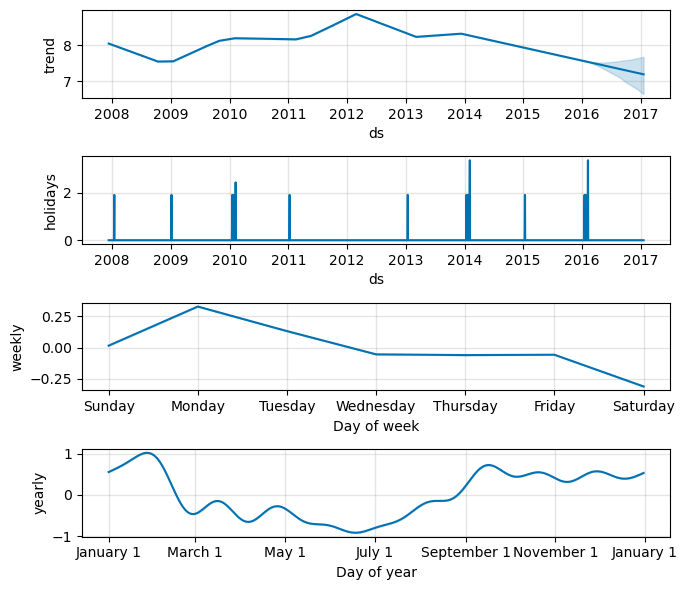

In [19]:
fig2 = model_holyday.plot_components(forecast, figsize=(7, 6))

- Now `plot_components` contains also the holidays component.
- Peyton won the Superbowl in 2016 while losing in 2010 and 2014. 
- We can see these spikes in the holidays chart.

- You can use a built-in collection of country-specific holidays using the `add_country_holidays`. 
- The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the holidays argument described before.
- A list of available countries and the country code is availble [here](https://github.com/vacanza/python-holidays/).

In [20]:
model_holyday2 = Prophet(holidays=holidays_df) # this includes the holidays we specified by hand
model_holyday2.add_country_holidays(country_name='US') # this the contruy-specific holidays
model_holyday2.fit(peyton)
print(model_holyday2.train_holiday_names)

19:44:25 - cmdstanpy - INFO - Chain [1] start processing
19:44:25 - cmdstanpy - INFO - Chain [1] done processing


0                         playoff
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Veterans Day
7                    Thanksgiving
8                   Christmas Day
9        Christmas Day (observed)
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
13        Veterans Day (observed)
14    Independence Day (observed)
15      New Year's Day (observed)
dtype: object


- As before, the country-level holidays will then show up in the components plot.

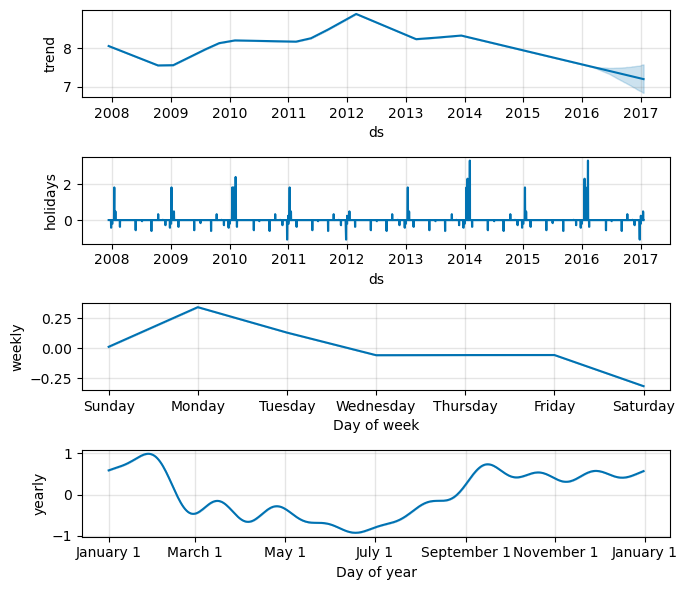

In [21]:
forecast = model_holyday2.predict(future)
fig = model_holyday2.plot_components(forecast, figsize=(7, 6))

### Saturating forecasts

- As discussed previously, Prophet allows you to make forecasts using a logistic growth trend model.
- Here, we will rely on the [Datasets Package](https://www.statsmodels.org/stable/datasets/index.html) from `statsmodels`.
- The list of available datasets is [here](https://vincentarelbundock.github.io/Rdatasets/articles/data.html).
- We need to do a bit of data preproccesing before using the data.

In [22]:
co2 = sm.datasets.get_rdataset("co2", "datasets").data
print(co2.head())

          time   value
0  1959.000000  315.42
1  1959.083333  316.31
2  1959.166667  316.50
3  1959.250000  317.56
4  1959.333333  318.13


In [23]:
# Convert decimal year to pandas datetime
def convert_decimal_year_to_datetime(decimal_years):
    dates = [(pd.to_datetime(f'{int(year)}-01-01') + pd.to_timedelta((year - int(year)) * 365.25, unit='D')).date() 
             for year in decimal_years]
    return dates

# Convert to Prophet format
co2['time'] = convert_decimal_year_to_datetime(co2['time'])
co2.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)

# Convert the column ds to datetime
co2['ds'] = pd.to_datetime(co2['ds'])
print("\nConverted:\n------------------\n", co2.head())


Converted:
------------------
           ds       y
0 1959-01-01  315.42
1 1959-01-31  316.31
2 1959-03-02  316.50
3 1959-04-02  317.56
4 1959-05-02  318.13


In [24]:
# Resample to monthly frequency based on the ds column
co2 = co2.resample('MS', on='ds').mean().reset_index()

# Replace NaN with the mean of the previous and next value
co2['y'] = co2['y'].interpolate()
print("\nResampled:\n------------------\n", co2.head())


Resampled:
------------------
           ds         y
0 1959-01-01  315.8650
1 1959-02-01  316.1825
2 1959-03-01  316.5000
3 1959-04-01  317.5600
4 1959-05-01  318.1300


- Next, we split the data in training set (first 90% of the data) and test set (remaining 10%).

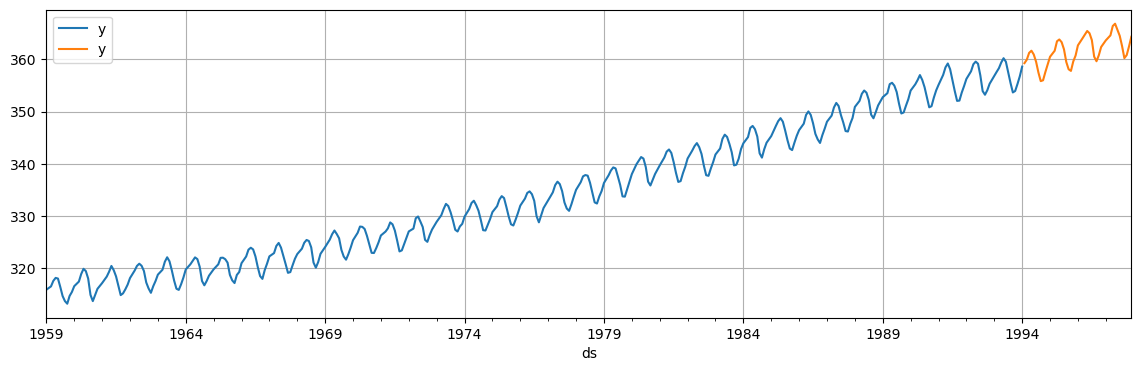

In [25]:
# Note that we need to make a copy here since we will modify the data
train = co2.iloc[:int(co2.shape[0] * 0.9)].copy()
test = co2.iloc[int(co2.shape[0] * 0.9):].copy()

fig, ax = plt.subplots(figsize=(10, 4))
train.plot(x='ds', y='y', figsize=(14, 4), grid=True, ax=ax)
test.plot(x='ds', y='y', figsize=(14, 4), grid=True, ax=ax)
plt.show()

- The logistic model requires to specify a carrying capacity, i.e., the maximum achievable point (total market size, total population size, etc..).
- The carrying capacity is specified in a column `cap`. 
- Here we will set an arbitrary value, but this would normally be set based on expertise and knowledge about the data.

In [26]:
train['cap'] = 360

- We then fit the model as before, except we change `growth='linear'` into `growth='logistic'`.

In [27]:
model_logist = Prophet(growth='logistic', # this has changed
                       seasonality_mode='additive', interval_width=0.90)
model_logist.fit(train);

19:44:26 - cmdstanpy - INFO - Chain [1] start processing
19:44:27 - cmdstanpy - INFO - Chain [1] done processing


- We make a dataframe for future predictions as before, except we must also specify the capacity in the future. 
- Here we set the capacity at the same value we used for historical data (`train['cap'] = 360`).
- Finally, we compute the forecast for the dates in the test set.

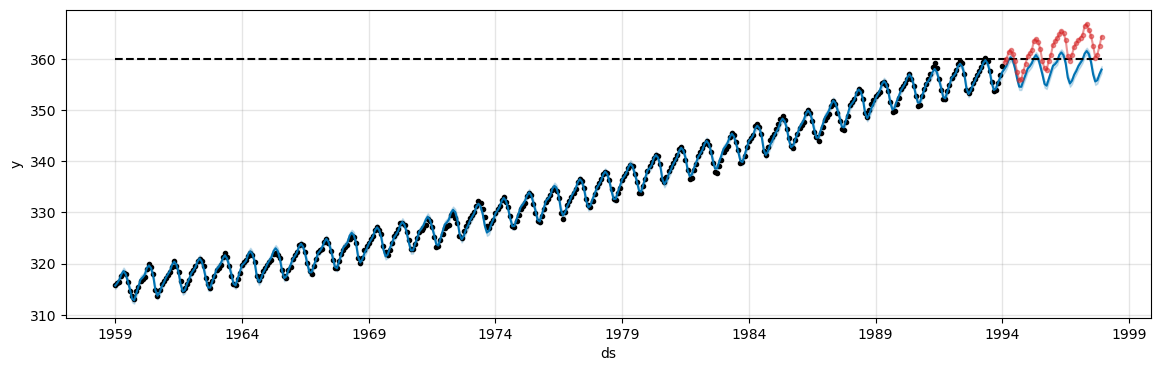

In [28]:
future = future = pd.DataFrame({'ds': pd.concat([train['ds'], test['ds']])}) # Init df for predictions
future['cap'] = 360                                                          # Set the cap
fcst = model_logist.predict(future)                                          # Compute forecasts
fig, ax = plt.subplots(figsize=(14, 4))
fig = model_logist.plot(fcst, ax=ax)
ax.plot(test['ds'], test['y'], 'tab:red', marker='o', markersize=3, alpha=0.5); 

- The model tries to keep the predictions under the specified `cap` value.
- The value is clearly too low in this case. Try with `cap=380` to get better predictions.

- The logistic growth model can also handle a saturating minimum.
- This is specified with a column `floor` in the same way as the `cap` column specifies the maximum.
- To use a logistic growth trend with a saturating minimum, a maximum capacity must also be specified.

19:44:27 - cmdstanpy - INFO - Chain [1] start processing
19:44:27 - cmdstanpy - INFO - Chain [1] done processing


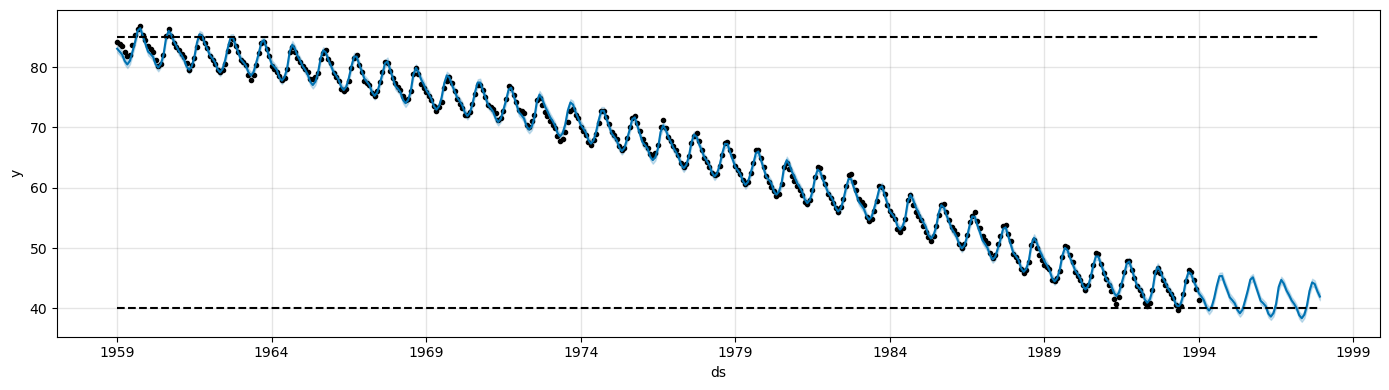

In [29]:
train['y'] = 400 - train['y'] # Modify the data so that the time series decreases over time
train['cap'] = 85
train['floor'] = 40
future['cap'] = 85
future['floor'] = 40
m = Prophet(growth='logistic')
m.fit(train)
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(14, 4))

### Trend changepoints

- Real time series frequently have abrupt changes in their trajectories. 
- By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. 
- However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

- Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. 
- Through a L1 regularization that encourages sparsity, it use as few of them as possible. 
- Let's consider again the Peyton Manning data.

In [30]:
# Data already log-transformed
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

19:44:28 - cmdstanpy - INFO - Chain [1] start processing
19:44:28 - cmdstanpy - INFO - Chain [1] done processing


- Prophet specifies 25 *potential changepoints* which are uniformly placed in the first 80% of the time series. 
- The vertical lines indicate where the potential changepoints were placed.

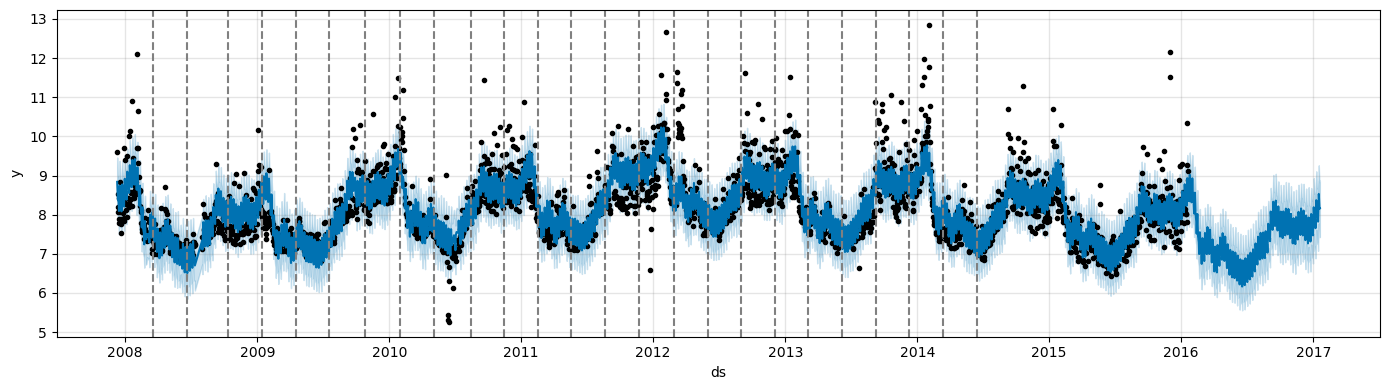

In [31]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.0, cp_color='gray', trend=False)

- Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints are not used. 
- We can see this by plotting the magnitude of the rate change at each changepoint.
- We keep only those where the magnitude of the rate change is significant.

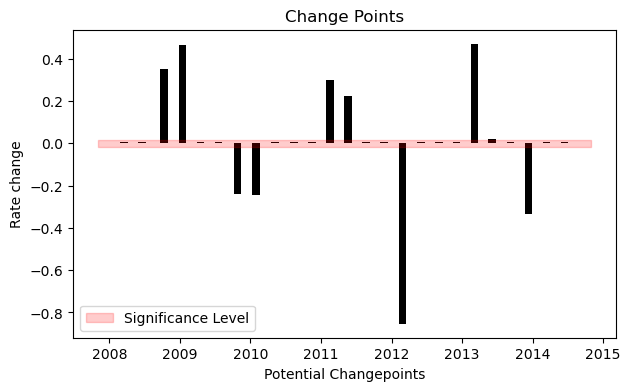

In [32]:
fig, ax = plt.subplots(figsize=(7, 4))
eps = 5e-3  # small offset to improve visualization
ax.bar(m.changepoints, np.nanmean(m.params['delta'], axis=0)+eps, color='k', width=40)
ax.fill_between(ax.get_xlim(), 0.01+eps, -0.01-eps, color='r', alpha=0.2, label='Significance Level')
ax.set_title('Change Points')
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential Changepoints')
plt.legend()
plt.show()

- Only 9 out of 25 potential changepoints are actually kept.
- We can visualize them on the actual data.

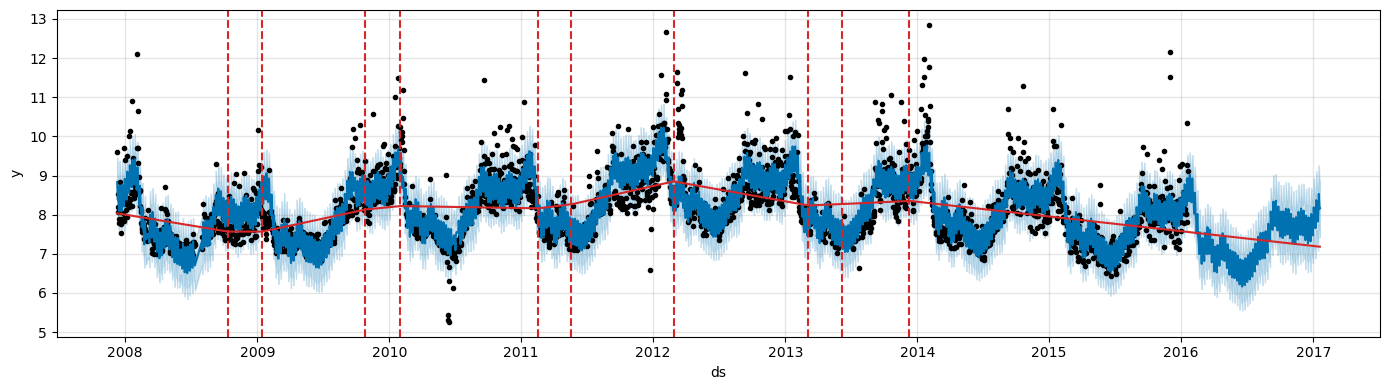

In [33]:
fig = m.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.01, cp_color='tab:red', trend=True)

- By default changepoints are only inferred for the first 80% of the time series.
- This allows having plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. 
- This default works in many situations but not all, and can be changed using the `changepoint_range` argument. 
- For example, `m = Prophet(changepoint_range=0.9)` will place potential changepoints in the first 90% of the time series.
- This can be useful in situation where there are important changes in the trend towards the end of the time series.

#### Adjusting trend flexibility

- If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparsity prior using the input argument `changepoint_prior_scale`. 
- By default, this parameter is set to 0.05. 
- Increasing it will make the trend more flexible.

19:44:29 - cmdstanpy - INFO - Chain [1] start processing
19:44:29 - cmdstanpy - INFO - Chain [1] done processing


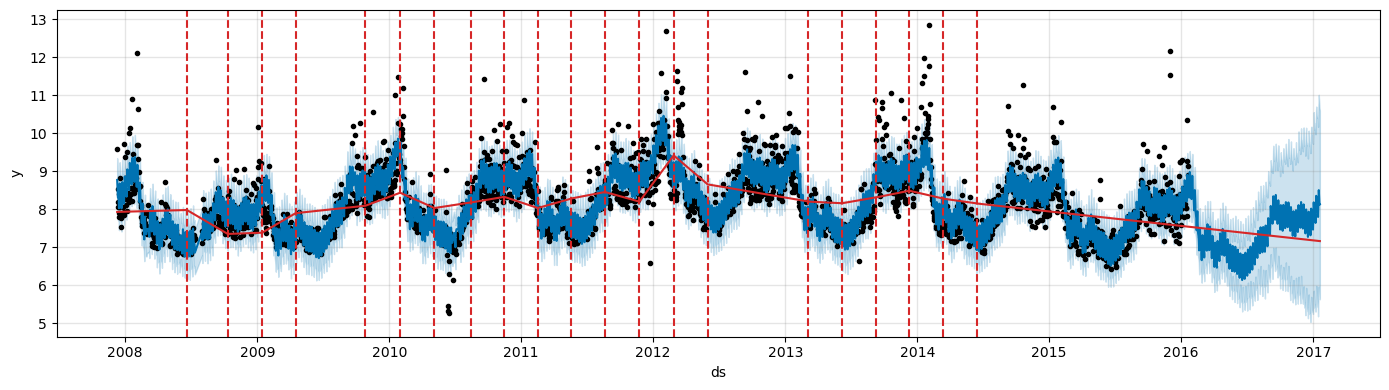

In [34]:
m = Prophet(changepoint_prior_scale=0.5) # Increase prior
forecast = m.fit(df).predict(future)
fig = m.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.01, cp_color='tab:red', trend=True)

- Decreasing it will make the trend less flexible.

19:44:30 - cmdstanpy - INFO - Chain [1] start processing
19:44:30 - cmdstanpy - INFO - Chain [1] done processing


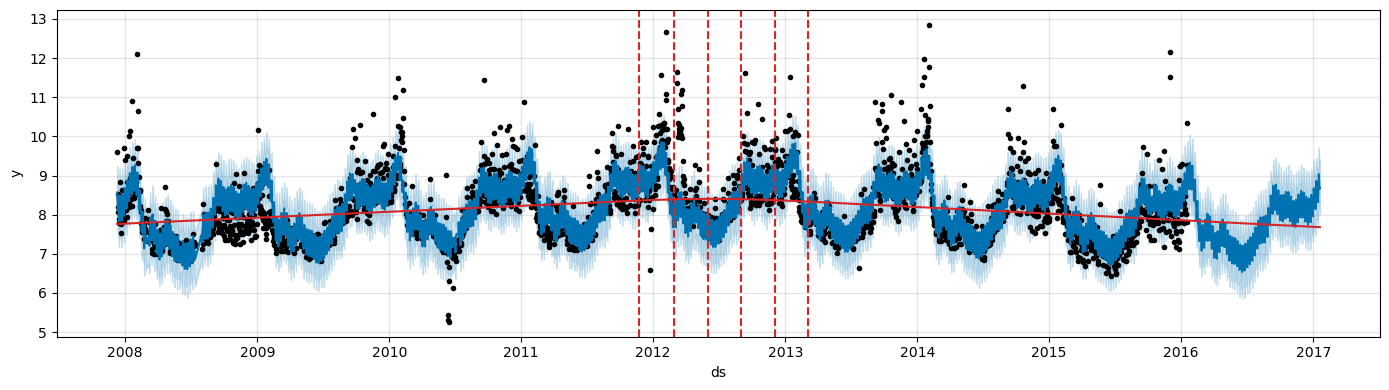

In [35]:
m = Prophet(changepoint_prior_scale=0.001) # Decrease prior
forecast = m.fit(df).predict(future)
fig = m.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.01, cp_color='tab:red', trend=True)

#### Specifying the locations of the changepoints

- You can manually specify the locations of potential changepoints with the `changepoints` argument. 
- Slope changes will then be allowed only at these points, with the same sparse regularization as before. 
- One could, for instance, create automatically a grid of points.
- Then, augment the grid with some specific dates that are known to be likely to have changes. 
- Alternatively, the changepoints could be entirely limited to a small set of dates, as is done here.

19:44:31 - cmdstanpy - INFO - Chain [1] start processing
19:44:31 - cmdstanpy - INFO - Chain [1] done processing


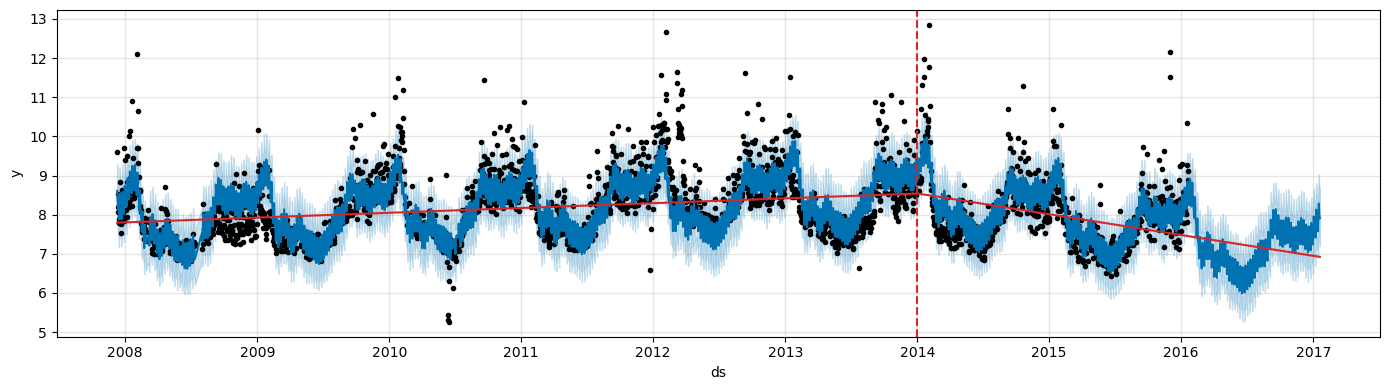

In [36]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast, figsize=(14, 4))
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.01, cp_color='tab:red', trend=True)

---

## Summary

- Prophet's methodology offers a flexible and intuitive approach to time series forecasting. 
- By decomposing the time series into trend, seasonality, and holiday components, it captures various patterns in the data. 
- Using Fourier series for seasonality and logistic or piece-wise linear growth for the trend allows Prophet to handle a wide range of forecasting scenarios.

---

## Exercises

Let's consider a time series of monthly retail sales index in the Netherlands from 1960 to 1995.

In [37]:
sales = sm.datasets.get_rdataset("DutchSales", "AER").data
print("Raw data:\n------------------\n", sales.head())

Raw data:
------------------
           time  value
0  1960.333333     14
1  1960.416667     13
2  1960.500000     15
3  1960.583333     13
4  1960.666667     13


1. Do the required preproccesing and convert the data to Prophet format.
2. Split the data in training and test data, using the first 90% and last 10% of the time series, respectively.
3. Fit a Prophet model to the data using a linear trend and make a forecast for the period of the test data.
4. Make the forecast with a model that includes the national holidays.
5. Adjust the trend by modifying the `changepoint_range` and `changepoint_prior_scale`. For each parameter, try at least two different values from the default ones.
6. Make the forecasts with a model with logistic trend.
7. Compare the performance of the models obtained at steps 3-6 in terms of MSE and MAPE on the test data.